In [30]:
# Importare le librerie
import tweepy
from dotenv import dotenv_values
# Importare le variabili d'ambiente dal file .env
config = dotenv_values(".env")

Definiamo le funzioni serealize_json e read_json che ci serviranno rispettivamente per salvare dati in locale e leggere file JSON da locale, servendoci delle librerie json e os.

In [58]:
# %load utils.py
import json
import os


def serealize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}.json", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}.json")

def read_json(path):
    try:
        if os.path.exists(path):
            with open(path, "r", encoding="utf-8") as file:
                data = json.load(file)
            return data
    except ValueError:
        print("Path not found, check the correctness of the path")


Utilizzo la libreria Tweepy per creare un client. Esso interagirà con la Twitter API. La libreria Tweepy permette di astrarre le chiamate HTTP per interagire con la Twitter API semplificandone l'utilizzo.


Creiamo un client Tweepy utilizzando il `BREARER_TOKEN` presente nel file `.env` e caricato tramite la libreria `dotenv`.


In [32]:
# Nuovo client Tweepy
client = tweepy.Client(bearer_token=config["BEARER_TOKEN"], wait_on_rate_limit=True)

Creo una funzione generica get_parsed_users_followers(id) che mi restituisce un dizionario di tutti i follower di un utente e per ciascuno di essi le seguenti informazioni salvate: attributi di default, descrizione del profilo, metriche pubbliche e se l'account è protetto. 
Questa funzione verrà spesso utilizzata successivamente.

In [33]:
def get_parsed_users_followers(id):
    followers = {}
    paginator = tweepy.Paginator(client.get_users_followers, id=id, user_fields=[
                                 "public_metrics", "protected", "description"], max_results=1000, limit=5).flatten(limit=1000)
    for follower in paginator:
        found_follower = {
            'name': follower.name,
            'username': follower.username,
            'description': follower.description,
            'public_metrics': follower.public_metrics,
            "protected": follower.protected
        }
        followers[follower.id] = found_follower
    return followers


## Punto 1
Usando la libreria tweepy e la funzione get_parsed_users_followers(id) da noi definita nel punto precedente scarico tutti i follower del profilo twitter dell'utente con username @KevinRoitero, ciascuno con le seguenti informazioni: attributi di default, la descrizione del profilo, le metriche pubbliche e se l'account è protetto o no.


In [34]:
kevin = client.get_user(username="KevinRoitero", user_fields=["public_metrics", "protected", "description"]).data
followers = get_parsed_users_followers(kevin.id)

In [35]:
# print(f'Followers count: {len(followers)}')
serealize_json(".", "followers", followers)

Data serialized to path: ./followers.json


## Punto 2
Per ciascun follower del profilo di @KevinRoitero utilizziamo tweepy per scaricare il numero di tweet pubblicati durante gli ultimi 7 giorni e aggiungiamo il risultato al JSON prodotto al punto 1.

In [ ]:
for id in followers:
    last_week_tweets_count = 0
    recent_tweets_count = client.get_recent_tweets_count(
        query=f"from:{followers[id]['username']} -is:retweet", granularity="day").data
    for day in recent_tweets_count or []:
        last_week_tweets_count += day["tweet_count"]
    # aggiungo alle info di follower anche last_week_tweets_count
    followers[id]['last_week_tweets_count'] = last_week_tweets_count
# Aggiungere il numero di tweets nel JSON
serealize_json(".", "followers", followers)


## Punto 3


Per ciascuno dei follower di Kevin Roitero che hanno almeno un follower e che non sono account protetti scarico 1000 follower.

In [19]:
# filtro la lista di follower di kevin scegliendo solo i follower che hanno a loro volta almeno un follower e non sono protected
follower_id_filtrati = []

for id in followers:
    follower_count = followers[id]["public_metrics"]["followers_count"]
    protected = followers[id]["protected"]

    if (follower_count > 1 and protected == False):
        follower_id_filtrati.append(id)


In [ ]:
#scarico i 1000 follower
for id in follower_id_filtrati:
    sub_followers = get_parsed_users_followers(id)
    followers[id]["followers"] = sub_followers

#salvo i risultati
serealize_json(".", "followers", followers)

## Punto Pre-4
Dato che il punto 3 impega circa 2 ore per generare tutti i dati, li abbiamo salvati all'interno di un file JSON. Per leggere tale file usiamo la funzione `read_json()` 

In [39]:
followers = read_json("followers_completed.json")

## Punto 4


4.1 Utilizzando NetworkX costruiamo un grafo diretto in cui i nodi sono KevinRoitero e i suoi follower e gli id e gli attributi sono gli strssi dei profili considerati.
4.2. Utilizzando il JSON prodotto al punto 3 abbiamo aggiunto al grafo un arco per ogni coppia di profili per cui esiste una relazione di following tra i due profili nei dati
recuperati al punto 3.

In [45]:
import networkx as nx
from networkx.readwrite import json_graph

In [46]:
def get_follower_attributes(id):
    return {
        'username': followers[id]['username'],
        'description': followers[id]['description'],
        'followers_count': followers[id]['public_metrics']['followers_count']
    }

In [42]:
#agiungo i nodi
graph1 = nx.DiGraph()

graph1.add_node(kevin.id,attr={
    'username': kevin.username,
    'description': kevin.description,
    'followers_count': kevin.public_metrics['followers_count']
})
for id in followers:
    graph1.add_node(id, attr=get_follower_attributes(id))


In [56]:
# Check if A follow B
def follow_check(A, B):
    if ("followers" in followers[B]):
        if A in followers[B]["followers"]:
            return True
        return False


#aggiungo gli archi
for A in followers:
    graph1.add_edge(A,kevin.id)

for A in followers:
    for B in followers:
        if follow_check(A, B):
            graph1.add_edge(A,B)

serealize_json("graphs","grafo_diretto",json_graph.node_link_data(graph1))


Data serialized to path: graphs/grafo_diretto.json


## Punto 5

Trasformiamo il grafico da diretto a indiretto e utilizziamo il metodo del Preferential Attachment per ampliare il grafo con nuovi nodi.

In [57]:
#trasformiamo il grafico da diretto a indiretto
graph2 = graph1.to_undirected()

#utilizziamo metodo del preferential attachment
graph2 = nx.barabasi_albert_graph(n = graph2.number_of_nodes()*2, m = 2, initial_graph=graph2)

#salviamo i dati
serealize_json("graphs","grafo_indiretto",json_graph.node_link_data(graph2))

Data serialized to path: graphs/grafo_indiretto.json


## Punto 6

Visualizziamo i due grafi utilizzando le librerie Pyvis ,per la visualizzazione interattiva, e Networkx, per la versione statica.

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


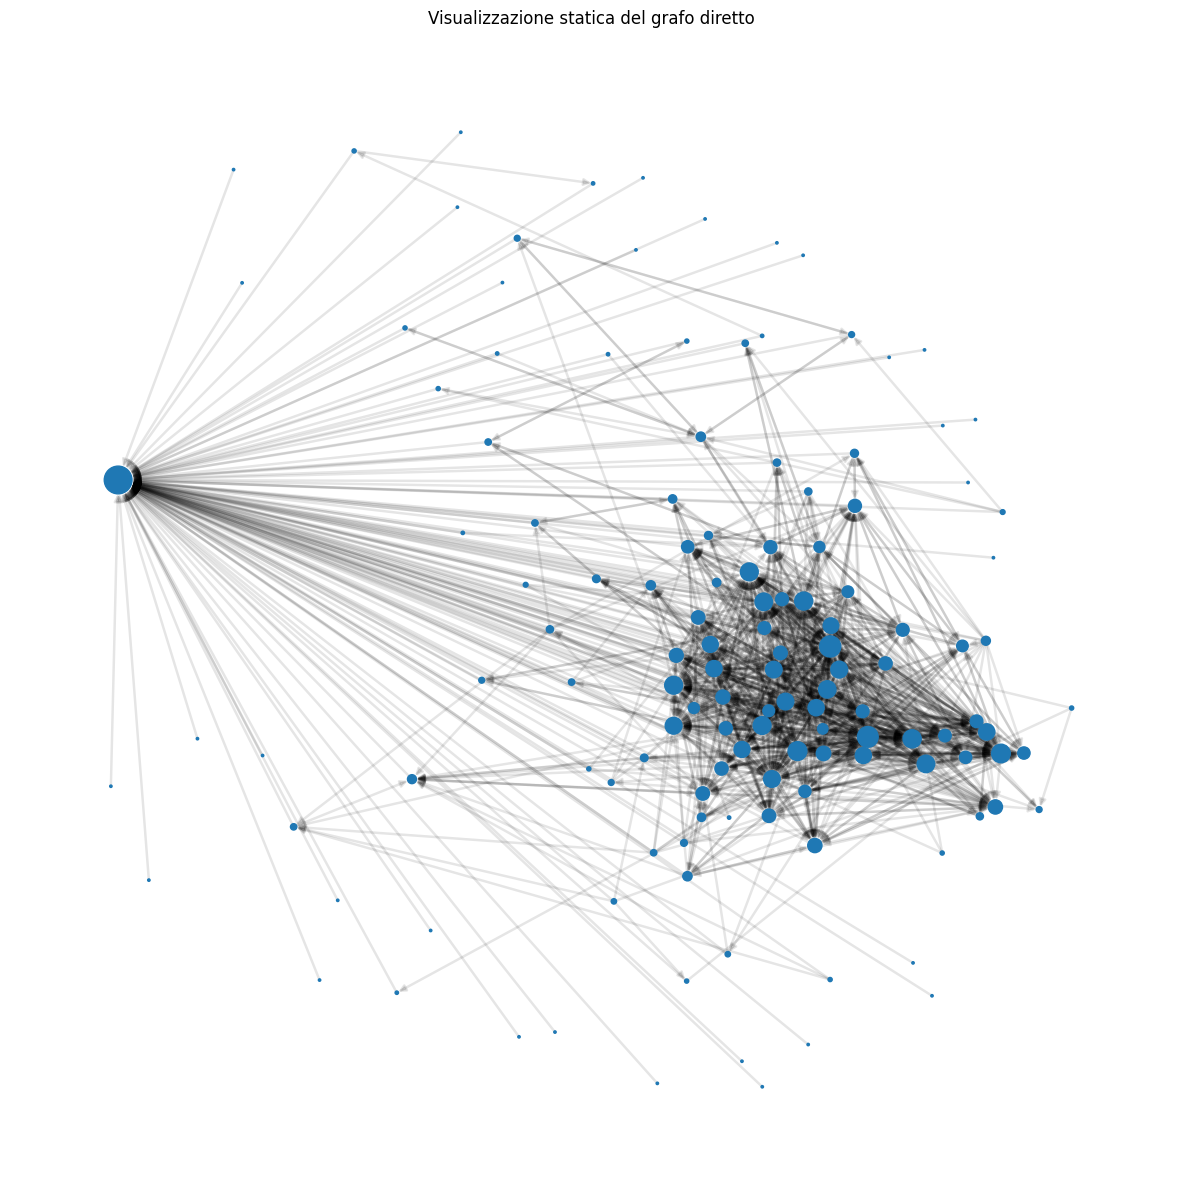

In [13]:
# GRAFO DIRETTO (graph1): 
# Grafico interattivo
import pyvis

visual_graph1 = pyvis.network.Network(height="100vh", notebook=True)
visual_graph1.barnes_hut()
visual_graph1.from_nx(graph1)
visual_graph1.show("html/grafo_diretto_interattivo.html")


# Grafico statico
import matplotlib.pyplot as plt

nx.draw_networkx(
    graph1,
    pos=nx.spring_layout(graph1),
    node_size = [x[1]*3 for x in list(graph1.degree)],
    with_labels = False,
    edge_color = (0,0,0,0.1),
    width = 1.8
)

fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.title("Visualizzazione statica del grafo diretto")
plt.axis('off')
plt.savefig("graphs/grafo_diretto_statico.pdf", dpi=100)
plt.show()

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


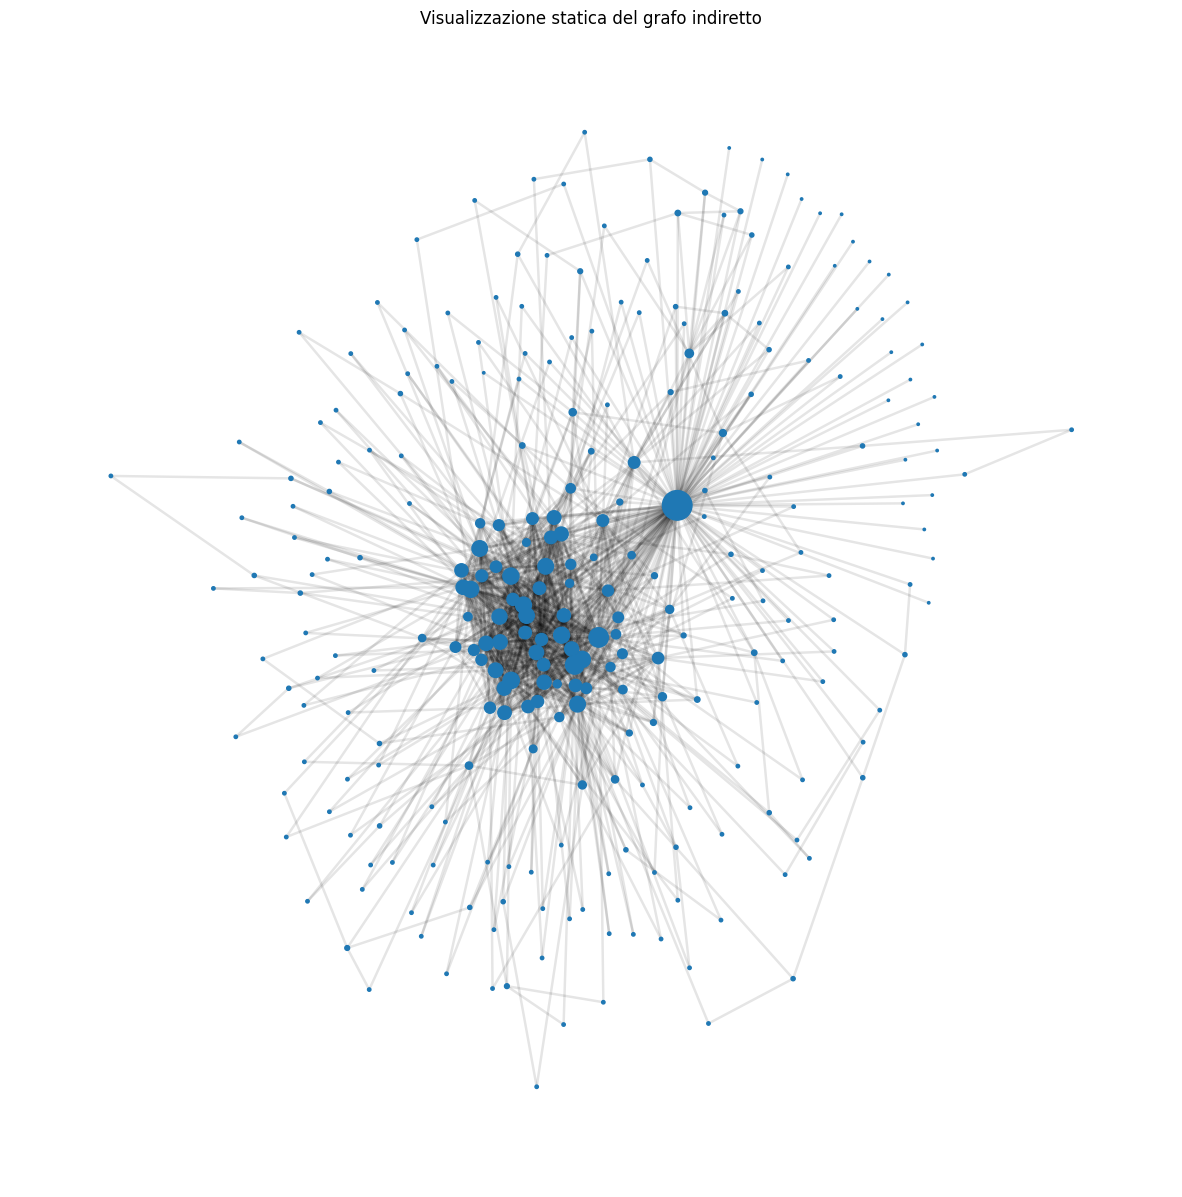

In [14]:
#GRAFO INDIRETTO (graph2):
# Grafico interattivo
visual_graph2 = pyvis.network.Network(height="100vh", notebook=True)
visual_graph2.barnes_hut()
visual_graph2.from_nx(graph2)
visual_graph2.show("html/grafo_indiretto_interattivo.html")


# Grafico statico
import matplotlib.pyplot as plt

nx.draw_networkx(
    graph2,
    pos=nx.spring_layout(graph2),
    node_size = [x[1]*3 for x in list(graph2.degree)],
    with_labels = False,
    edge_color = (0,0,0,0.1),
    width = 1.8
)
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.title("Visualizzazione statica del grafo indiretto")
plt.axis('off')
plt.savefig("graphs/grafo_indiretto_statico.pdf", dpi=100)
plt.show()

## Punto 7

Per ciascuno dei due grafi identifichiamo la più grande componente fortemente connessa e produciamo una visualizzazione statica del grafo mettendo in risalto i nodi appartenenti alla scc.

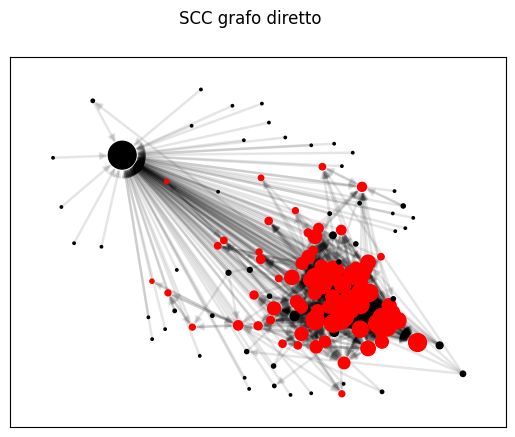

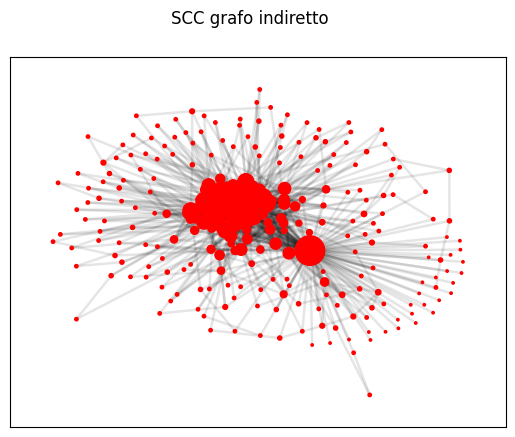

In [15]:
def grafico(graph,scc):
    node_colors = dict(graph.nodes)
    for node in node_colors:
        if node in scc:
            node_colors[node] = 'red'
        else:
            node_colors[node] = 'black'

    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        node_size = [x[1]*3 for x in list(graph.degree)],
        node_color= list(node_colors.values()),
        with_labels = False,
        edge_color = (0,0,0,0.1),
        width = 1.8
    )

#Calcolo della componente fortemente connessa più grande
scc1 = max(nx.strongly_connected_components(G=graph1), key=len)
scc2 = max(nx.connected_components(G=graph2), key=len)


fig1 = plt.figure()
fig1.suptitle("SCC grafo diretto")
grafico(graph1,scc1)
fig2 = plt.figure()
fig2.suptitle("SCC grafo indiretto")
grafico(graph2,scc2)


from matplotlib.backends.backend_pdf import PdfPages
def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

save_multi_image("./graphs/scc.pdf")


## Punto 8

Misuriamo centro, raggio, distanza media e distanza massima dei due grafi

In [16]:
#GRAFO DIRETTO (graph1):
# Essendo il grafo diretto (graph1) weakly-connected (per esempio il nodo Kevin non è collegato a nessun nodo)
# è possibile svolgere le misurazioni solo nel grafo indiretto
# Nonostante ciò, per ovviare a questo "problema" è possibile convertire il grafo diretto in indiretto, senza aggiungere nuovi nodi
graph3 = graph1.to_undirected()
print(f"Centro: {nx.center(graph3)}")
print(f"Raggio: {nx.radius(graph3)}")
print(f"Distanza media: {nx.average_shortest_path_length(graph3)}")
print(f"Distanza massima (diametro): {nx.diameter(graph3)}")

Centro: [3036907250]
Raggio: 1
Distanza media: 1.8938390753001908
Distanza massima (diametro): 2


In [17]:
#GRAFO INDIRETTO (graph2):
print(f"Centro: {nx.center(graph2)}")
print(f"Raggio: {nx.radius(graph2)}")
print(f"Distanza media: {nx.average_shortest_path_length(graph2)}")
print(f"Distanza massima (diametro): {nx.diameter(graph2)}")

Centro: [3036907250, '2582519183', '998681467696885761', '553507111', '1275818050848206848', '28607182', '1546349170315120640', '1520733236678299650', '2989739661', '1511721268558630916', '248721193', '1708743114', '1269179580843200512', '465693357', '75525450', '1222505104080809985', '833597084167122945', '40576466', '1387788296215015428', '29866761', '1190461842922995712', '22597445', '1330708819761004545', '554687023', '338989477', '1187585868493537280', '39697728', '1265795638551212032', '184125091', '839139788846411777', '1111315973125169152', '391867472', '514667085', '18874262', '393675585', '249661913', '2382305514', '130671142', '16868154', '59217922', '934851466082357249', '94732055', '947311503216066560', '458399248', '78969930', '4053818032', '406303880', '132646210', '14451127', '3102522680', '3033312071', '2309104237', '15455450', '125483940', '436609034', '308456550', '810893744593584128', '18932422', '341000847', '2190533245', '2601589496', '15750573', 150]
Raggio: 3
Di

## Punto 9

Calcoliamo Betweennes centrality, Closeness Centrality, Degree Centrality, In-degree centrality, Out-degree entrality, Page Rank e Hits, andando in ultimo a visualizzare tutte le misurazioni in dei grafi.

In [28]:
def draw(graph, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(
        graph,
        pos,
        node_size=150,
        cmap=plt.cm.plasma,
        node_color=list(measures.values()),
        nodelist=measures.keys()
    )
    edges = nx.draw_networkx_edges(graph,pos)
    figure = plt.gcf()
    figure.suptitle(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')

In [29]:
def centrality(graph,filename):
    plt.figure()
    draw(
        graph,
        nx.spring_layout(graph),
        nx.betweenness_centrality(graph),
        'Betweenness Centrality'
    )
    plt.figure()
    draw(
        graph,
        nx.spring_layout(graph),
        nx.closeness_centrality(graph),
        'Closeness Centrality'
    )
    plt.figure()
    draw(
        graph,
        nx.spring_layout(graph),
        nx.degree_centrality(graph),
        'Degree Centrality'
    )
    if nx.is_directed(graph):
        plt.figure()
        draw(
            graph,
            nx.spring_layout(graph),
            nx.in_degree_centrality(graph),
            'In-Degree Centrality'
        )
    if nx.is_directed(graph):
        plt.figure()
        draw(
            graph,
            nx.spring_layout(graph),
            nx.out_degree_centrality(graph),
            'Out-Degree Centrality'
        )
    plt.figure()
    draw(
        graph,
        nx.spring_layout(graph),
        nx.pagerank(graph),
        'Page Rank'
    )
    plt.figure()
    draw(
        graph,
        nx.spring_layout(graph),
        nx.hits(graph)[0],
        'HITS'
    )
    #print(f"Hits: {nx.hits(graph)}")
    save_multi_image(f"./graphs/{filename}.pdf")
    plt.close('all')


centrality(graph1,"misurazioni_grafo_diretto")
centrality(graph2,"misurazioni_grafo_indiretto")

c:\Users\drago\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)
c:\Users\drago\miniconda3\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


## Punto 10

Calcoliamo i coefficienti Omega e Sigma per stimare la "small worldness" del grafo indiretto

In [26]:
omega = nx.omega(graph2, niter = 10, nrand = 3)
print(f"Omega: {omega}")
sigma = nx.sigma(graph2, niter = 10, nrand = 3)
print(f'Sigma: {sigma}')

Omega: 0.1973801941208444
Sigma: 1.3457438647725815
